# Assignment 2

In [6]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import random
from time import time

from data_rnn import load_ndfa, load_brackets

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import torch.distributions as dist

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda') 
else:
    device = torch.device('cpu') 

device

device(type='cpu')

### Load data

In [4]:
# NDFA
x_train, (i2w, w2i) = load_ndfa(n=150_000)

# # Brackets
# x_train, (i2w, w2i) = load_brackets(n=150_000)

In [5]:
len(x_train)

150000

In [6]:
x_train[0]

[12, 12]

In [4]:
def print_sequence(seq):
    if seq[0] == w2i['.start']:
        seq = seq[1:]
    if seq[-1] == w2i['.end']:
        seq = seq[:-1]
        
    print(''.join([i2w[i] for i in seq]) )


In [48]:
print_sequence(x_train[10_000])

ss


In [9]:
vocab_size = len(w2i)
vocab_size

15

In [10]:
w2i

{'.pad': 0,
 '.start': 1,
 '.end': 2,
 '.unk': 3,
 'l': 4,
 'k': 5,
 'm': 6,
 'u': 7,
 'v': 8,
 'w': 9,
 'a': 10,
 'c': 11,
 's': 12,
 'b': 13,
 '!': 14}

In [14]:
def get_max_seq_length(batch):
    return max(len(seq) for seq in batch)

In [15]:
def get_sum_seq_lengths(batch):
    return sum(len(seq) for seq in batch)

In [16]:
def add_padding(seq, amt=1):
    for _ in range(amt):
        seq.append(w2i['.pad'])
    return seq

In [17]:
def add_start(seq):
    seq.insert(0, w2i['.start'])
    return seq

In [18]:
def add_end(seq):
    seq.append(w2i['.end'])
    return seq

In [16]:
print(f'The longest sequence in trainset has {get_max_seq_length(x_train)} length.')

The longest sequence in trainset has 158 length.


In [17]:
print(f'Mean length of a sequence in trainset is {get_sum_seq_lengths(x_train) / len(x_train)}.')

Mean length of a sequence in trainset is 13.96264.


In [21]:
def preprocess_batch(batch):
    max_len = get_max_seq_length(batch)
    
    upd_batch = []
    for i, _ in enumerate(batch):
        seq = batch[i].copy()
        seq = add_start(seq)
        seq = add_end(seq)
        seq = add_padding(seq, amt=max_len + 2 - len(seq))
        upd_batch.append(seq)
    
    upd_batch = torch.tensor(upd_batch, dtype=torch.long)
    return upd_batch

In [22]:
def get_batches(data, max_token_amount=10000):
    batches, targets = [], []
    bound_l, bound_r = -1, 0

    while bound_r < len(data):
        bound_l = bound_r

        num_of_tokens = 0
        while bound_r < len(data) and (num_of_tokens + len(data[bound_r])) < max_token_amount:
            num_of_tokens += len(data[bound_r])
            bound_r += 1
        print(bound_l, bound_r)
        batch = data[bound_l:bound_r]
        batch = preprocess_batch(batch)
        target = F.pad(batch, (0, 1), "constant", 0)[:, 1:]
        # target = F.one_hot(target, num_classes=vocab_size)

        batches.append(batch)
        targets.append(target)
    return batches, targets


In [23]:
def batch_generator(batches, targets):
    indices = list(range(len(batches)))
    random.shuffle(indices)
    # print(f'Shuffle: {indices}')
    
    for ind in indices:
        yield batches[ind], targets[ind], (len(batches[ind]), len(batches[ind][0]))

## Question 5

In [24]:
class Net(nn.Module):
    def __init__(self, vocab_size, embedding_size=32, hidden_size=16, lstm_num_layers=3) -> None:
        super().__init__()

        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, lstm_num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, input):
        x = input
        x = self.embed(x)
        x, (hn, cn) = self.lstm(x)
        output = self.linear(x)
        return output

In [50]:
net = Net(vocab_size)
net

Net(
  (embed): Embedding(15, 32)
  (lstm): LSTM(32, 16, num_layers=3, batch_first=True)
  (linear): Linear(in_features=16, out_features=15, bias=True)
)

In [25]:
def sample(lnprobs, temperature=1.0):
    """
    Sample an element from a categorical distribution
    :param lnprobs: Outcome logits
    :param temperature: Sampling temperature. 1.0 follows the given
    distribution, 0.0 returns the maximum probability element.
    :return: The index of the sampled element.
    """
    if temperature == 0.0:
        return lnprobs.argmax()

    p = F.softmax(lnprobs / temperature, dim=0)
    cd = dist.Categorical(p)
    
    return cd.sample()

In [26]:
def generate_seq(model, w2i, start_seq, max_length=25, temp=1.0, device=torch.device('cpu')):
    new_seq = start_seq.copy()
    start_seq = torch.tensor(start_seq, dtype=torch.long).to(device)
    start_seq = start_seq[None, :]

    output = model(start_seq)
    last_token = sample(output[0, -1, :])

    curr_len = len(start_seq)
    while curr_len < max_length and last_token.item() != w2i['.end']:
        new_seq.append(last_token.item())
        curr_len += 1

        output = model(last_token.reshape(1, 1))
        last_token = sample(output[0, -1, :])
    new_seq.append(last_token)
    
    return new_seq


In [183]:
def train(model, batches, targets, start_seq, epochs=3, learning_rate=0.01, 
    grad_limit=3, max_length=25, temp=1.0, device=torch.device('cpu')):
        
    criterion = nn.CrossEntropyLoss(reduction='sum', ignore_index=w2i['.pad'])
    # criterion = nn.CrossEntropyLoss(reduction='sum')
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.to(device)
    model.train()

    metrics = {
        'loss_history': [], # loss per iteration
        'loss_train': [], # loss per epoch
        'loss_history_per_token': [] # loss per token on iteratiom
    }

    samples = defaultdict(list)

    total_loss = []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n-------------------------------")

        for i, (x_batch, y_batch, _) in enumerate(batch_generator(batches, targets)):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            assert x_batch.shape == y_batch.shape

            optimizer.zero_grad()

            start_time = time()
            outputs = model(x_batch)
            # print(outputs.shape)
            loss = criterion(outputs.reshape(outputs.shape[0]*outputs.shape[1], -1), y_batch.reshape(y_batch.shape[0]*y_batch.shape[1], )) # outputs: [batch_size*time, vocab_size], y:[batch_size*time]
            loss.backward()
            finish_time = time()

            num_tokens = (y_batch != 0).sum().item()

            # print statistics
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss.item() / num_tokens:.6f} time: {finish_time - start_time:.3f}')
            metrics['loss_history_per_token'].append(loss.item() / num_tokens) # loss per token for each iteration
            metrics['loss_history'].append(loss.item())
            total_loss.append(loss.item())

            nn.utils.clip_grad_norm_(model.parameters(), grad_limit)
            optimizer.step()

        metrics['loss_train'].append(np.mean(total_loss)) # mean loss per epoch

        for _ in range(10):
            samples[epoch].append(generate_seq(model, w2i, start_seq, max_length, temp, device))
            
    return model, metrics, samples

In [60]:
vocab_size=len(w2i)
max_token_amount = 50000


embedding_size = 32
hidden_size = 16
lstm_num_layers = 1

grad_limit = 5
max_length = 25
temp = 1.0

epochs = 3
learning_rate = 0.01

In [61]:
batches, targets = get_batches(x_train, max_token_amount=max_token_amount)
print(len(batches))

0 24999
24999 49998
49998 74997
74997 92323
92323 104822
104822 113338
113338 120164
120164 125505
125505 129703
129703 133086
133086 135875
135875 138200
138200 140137
140137 141784
141784 143176
143176 144358
144358 145368
145368 146234
146234 146978
146978 147621
147621 148174
148174 148644
148644 149042
149042 149374
149374 149642
149642 149853
149853 149995
149995 150000
28


In [62]:
batches[0][:5], targets[0][:5]

(tensor([[1, 5, 4, 2],
         [1, 5, 4, 2],
         [1, 5, 4, 2],
         [1, 5, 4, 2],
         [1, 5, 4, 2]]),
 tensor([[5, 4, 2, 0],
         [5, 4, 2, 0],
         [5, 4, 2, 0],
         [5, 4, 2, 0],
         [5, 4, 2, 0]]))

In [57]:
start_seq = [
    w2i['.start'],
    w2i['s'],
    w2i['a']
]

In [58]:
model = Net(vocab_size, embedding_size, hidden_size, lstm_num_layers)
model, metrics, samples = train(model, batches, targets, start_seq, w2i, epochs, learning_rate, grad_limit, max_length, temp, device)

Epoch 1
-------------------------------
[1,     1] loss: 2.630177 time: 0.194
[1,     2] loss: 2.501814 time: 0.164
[1,     3] loss: 1.478745 time: 0.184
[1,     4] loss: 2.384547 time: 0.119
[1,     5] loss: 2.321265 time: 0.183
[1,     6] loss: 1.243621 time: 0.244
[1,     7] loss: 1.866113 time: 0.116
[1,     8] loss: 1.868862 time: 0.109
[1,     9] loss: 2.032119 time: 0.115
[1,    10] loss: 1.938493 time: 0.144
[1,    11] loss: 1.679699 time: 0.143
[1,    12] loss: 1.796578 time: 0.095
[1,    13] loss: 1.775709 time: 0.102
[1,    14] loss: 1.582468 time: 0.124
[1,    15] loss: 1.411927 time: 0.158
[1,    16] loss: 1.582464 time: 0.192
[1,    17] loss: 1.339524 time: 0.119
[1,    18] loss: 1.512744 time: 0.097
[1,    19] loss: 1.103021 time: 0.127
[1,    20] loss: 1.543588 time: 0.104
[1,    21] loss: 1.332523 time: 0.128
[1,    22] loss: 1.134934 time: 0.104
[1,    23] loss: 1.129640 time: 0.104
[1,    24] loss: 0.965106 time: 0.110
[1,    25] loss: 1.019450 time: 0.097
[1,    26]

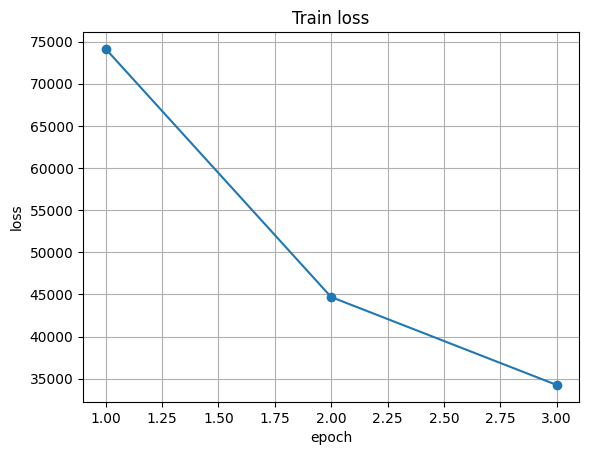

In [59]:
plt.plot(range(1, epochs + 1), metrics['loss_train'], marker='o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train loss')
plt.grid()
plt.show()

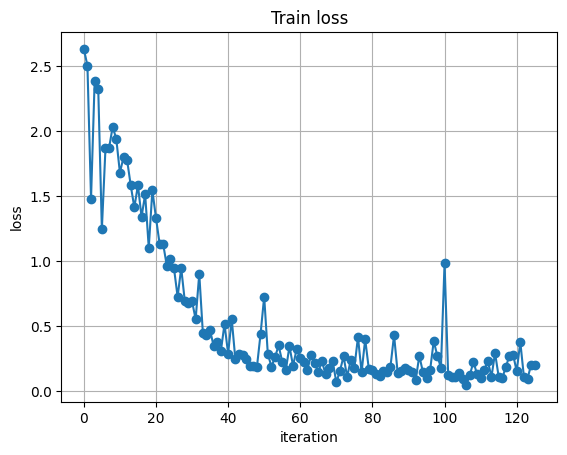

In [60]:
plt.plot(metrics['loss_history_per_token'], marker='o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Train loss')
plt.grid()
plt.show()

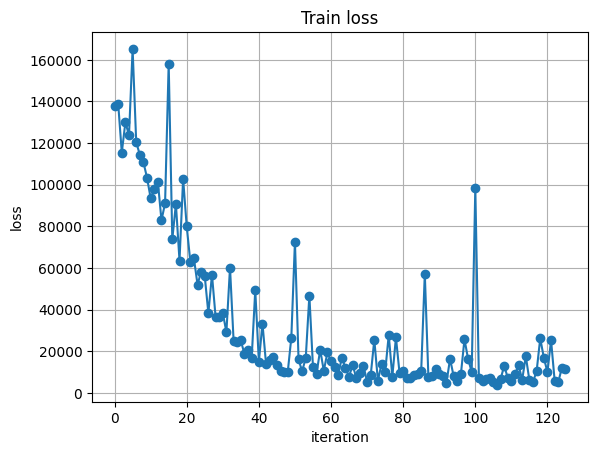

In [61]:
plt.plot(metrics['loss_history'], marker='o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Train loss')
plt.grid()
plt.show()

In [63]:
for epoch, generated in samples.items():
    print(f'EPOCH {epoch}')
    for seq in generated:
        print_sequence(seq)
    print()

EPOCH 0
sabcc!sw!s
saabvv!klm!.pad!avw!ab!llm!su.pad
sabc!s
sabc!abc!abc!u.padm!uvwsvwmmkw
sab!abc!.padl!uvw
sabc!uvw!avwsabc!abc!uvw!ab
saabc!uvvm!.unkuvvw!ks
sabc!
sabcsvw!uvw!abc!uvw
sa

EPOCH 1
sabc!abc!s
sabc!uvw!s
sab!s
sabc!s
sabc!abc!s
sabc!slm!abc!s
sabc!s
sabc!s
sabcc!s
sabc!uvw!s

EPOCH 2
sabc!s
sabc!suvw!c!s
sabc!s
sabc!s
sabc!s
sabc!abc!s
sabc!s
sabc!s
sabc!uvw!s
sabc!abc!abvw!uvw!abc!uvw!a



### Brackets

In [184]:
x_train, (i2w, w2i) = load_brackets(n=150_000)

In [185]:
print_sequence(x_train[140_000])

((()(((())(())(()))))(())())


In [186]:
vocab_size = len(w2i)
vocab_size

6

In [187]:
w2i

{'.pad': 0, '.start': 1, '.end': 2, '.unk': 3, ')': 4, '(': 5}

In [188]:
print(f'The longest sequence in trainset has {get_max_seq_length(x_train)} length.')

The longest sequence in trainset has 1022 length.


In [189]:
print(f'Mean length of a sequence in trainset is {get_sum_seq_lengths(x_train) / len(x_train)}.')

Mean length of a sequence in trainset is 9.01628.


In [190]:
vocab_size=len(w2i)
max_token_amount = 50000
embedding_size = 32
hidden_size = 16
lstm_num_layers = 3

grad_limit = 5
max_length = 50
temp = 0.6
epochs = 50
learning_rate = 0.001

In [191]:
batches, targets = get_batches(x_train, max_token_amount=max_token_amount)
print(len(batches))

0 24999
24999 49998
49998 74997
74997 92323
92323 104822
104822 113338
113338 120164
120164 125505
125505 129703
129703 133086
133086 135875
135875 138200
138200 140137
140137 141784
141784 143176
143176 144358
144358 145368
145368 146234
146234 146978
146978 147621
147621 148174
148174 148644
148644 149042
149042 149374
149374 149642
149642 149853
149853 149995
149995 150000
28


In [192]:
batches[0][:5], targets[0][:5]

(tensor([[1, 5, 4, 2],
         [1, 5, 4, 2],
         [1, 5, 4, 2],
         [1, 5, 4, 2],
         [1, 5, 4, 2]]),
 tensor([[5, 4, 2, 0],
         [5, 4, 2, 0],
         [5, 4, 2, 0],
         [5, 4, 2, 0],
         [5, 4, 2, 0]]))

In [193]:
start_seq = [
    w2i['.start'], w2i['('], w2i['('], w2i[')']
]

In [195]:
model = Net(vocab_size, embedding_size, hidden_size, lstm_num_layers)
model, metrics, samples = train(model, batches, targets, start_seq, epochs, learning_rate, grad_limit, max_length, temp, device)

Epoch 1
-------------------------------
[1,     1] loss: 1.728575 time: 0.752
[1,     2] loss: 1.808362 time: 0.636
[1,     3] loss: 1.718567 time: 0.835
[1,     4] loss: 1.783756 time: 0.752
[1,     5] loss: 1.704816 time: 0.514
[1,     6] loss: 1.797371 time: 0.649
[1,     7] loss: 1.694402 time: 0.576
[1,     8] loss: 1.707625 time: 0.507
[1,     9] loss: 1.720485 time: 0.421
[1,    10] loss: 1.670057 time: 0.467
[1,    11] loss: 1.659237 time: 0.418
[1,    12] loss: 1.648201 time: 1.139
[1,    13] loss: 1.659434 time: 0.451
[1,    14] loss: 1.636035 time: 0.655
[1,    15] loss: 1.675417 time: 0.441
[1,    16] loss: 1.615330 time: 0.612
[1,    17] loss: 1.601290 time: 0.730
[1,    18] loss: 1.612878 time: 0.524
[1,    19] loss: 1.714135 time: 0.492
[1,    20] loss: 1.566666 time: 1.261
[1,    21] loss: 1.762947 time: 1.518
[1,    22] loss: 1.570865 time: 1.374
[1,    23] loss: 1.662439 time: 0.892
[1,    24] loss: 1.527577 time: 0.906
[1,    25] loss: 1.573929 time: 0.671
[1,    26]

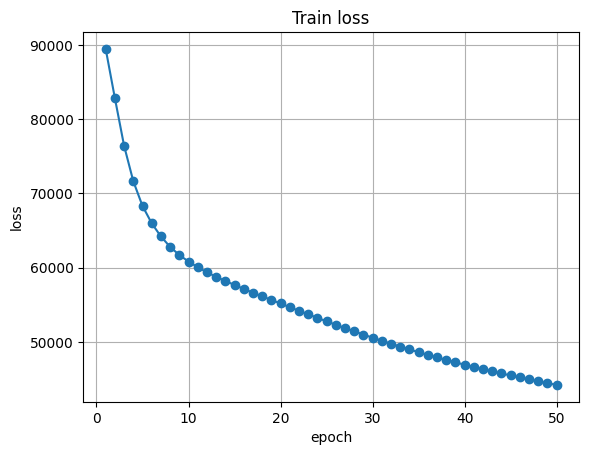

In [196]:
plt.plot(range(1, epochs + 1), metrics['loss_train'], marker='o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train loss')
plt.grid()
plt.show()

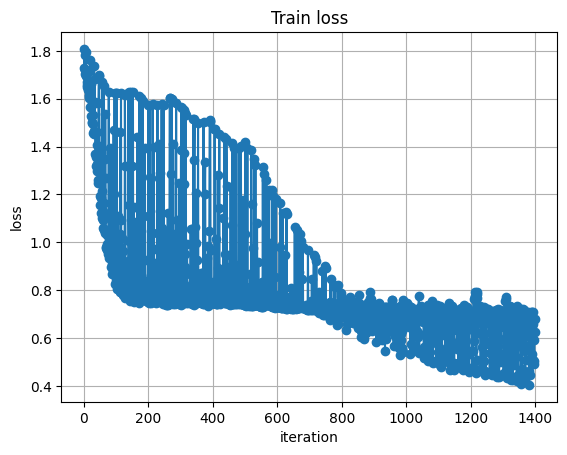

In [197]:
plt.plot(metrics['loss_history_per_token'], marker='o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Train loss')
plt.grid()
plt.show()

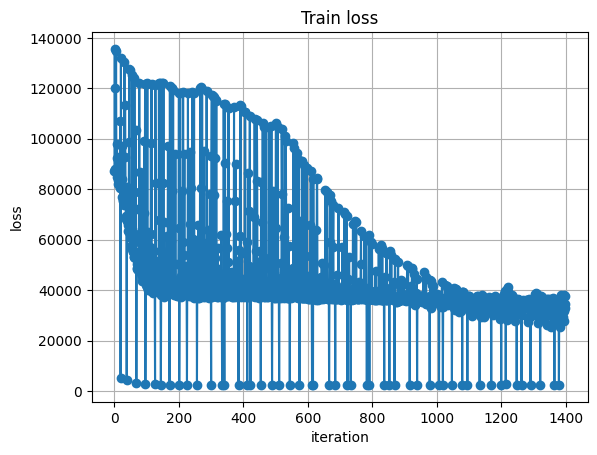

In [198]:
plt.plot(metrics['loss_history'], marker='o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Train loss')
plt.grid()
plt.show()

In [199]:
def validate_sequences(samples):
    stats = {}
    for epoch, generated in samples.items():
        ratio = list()
        valid = list()
        for seq in generated:
            opened, closed = 0., 0.
            for el in seq:
                if el == w2i['.start'] or el == w2i['.end']:
                    continue
                elif i2w[el] == '(':
                    opened += 1
                elif i2w[el] == ')':
                    closed += 1
            ratio.append(opened / (opened + closed))
            valid.append(opened == closed)

        stats[epoch] = {
            'ratio': ratio,
            'valid': sum(valid)
        }

    return stats


In [200]:
stats = validate_sequences(samples)

In [208]:
stats[49]

{'ratio': [0.8125,
  0.71875,
  0.8085106382978723,
  0.9333333333333333,
  0.5714285714285714,
  0.4,
  0.8421052631578947,
  0.875,
  0.6,
  0.5],
 'valid': 1}

In [209]:
for seq in samples[49]:
    print_sequence(seq)

(())((((((((((()
(()((((().pad).start((.pad).unk(((().pad(((((((().unk)(())
(()(((((().start)((((((((((()).pad.unk(()(((((((((((((().unk)).pad.pad(((
(()((((((((((((
(()).unk(()
(())).pad
(()((.pad.pad(((((().unk(((((()
(()((((().unk((((().unk(((((((((.unk
(()()
(())


In [213]:
for _ in range(10):
    print_sequence(generate_seq(model, w2i, start_seq, 30, 0.2, device))

(()(((((().start((((((().start(((((((().start(((
(()())((((((((((()
(()).start((()
(()).pad.unk).pad.pad.unk((((().pad
(())().pad
(()).unk
(())).unk).unk.pad
(()(((((().pad)
(()(((((((((((((().unk).pad
(()((((((().pad((((.pad
